## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card
* Bank account services
* Theft/Dispute reporting
* Mortgages/loans
* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
!pip install wordcloud

In [3]:
pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=21c306e494618e2a5488293602a775e380fa8a58704b1f8140f6b7e6b8e0eb82
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [4]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import swifter

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# hide warnings
import warnings
warnings.filterwarnings('ignore')


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Write the path to your data file and load it
path = "/content/drive/MyDrive/MS Projects/NLP/NLP Case Study - Automatic Ticket Classification/complaints-2021-05-14_08_16.json"
# Opening JSON file
f = open(path)
# returns JSON object as a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'complaints_what_happened', '_source.product':'tag'}, inplace=True)
#df.head()

In [9]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', 'tag',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely', 'complaints_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype='object')

In [10]:
df = df[['complaints_what_happened', 'tag']]

In [11]:

df = df[df['complaints_what_happened'].astype(bool)]
df.head()

,complaints_what_happened,tag
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text

In [13]:
# Apply data cleaning to the complaints_what_happened column

df['complaints'] = df['complaints_what_happened'].apply(clean_data)
df.head()

,complaints_what_happened,tag,complaints
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,good morning my name is and i appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,i upgraded my card in and was told by the agen...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card was reported on however fraudulent ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",on while trying to book a ticket i came across...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,my grand son give me check for i deposit it in...


In [14]:
import os
import nltk
# Download the 'wordnet' resource
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
#Write your function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame({'complaints':df['complaints'], 'lemmatized':df['complaints'].apply(lemmatization)})

In [17]:
df_clean.head()

,complaints,lemmatized
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [18]:
#Write your function to extract the POS tags

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str



In [19]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [62]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(20)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,3
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
17,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restricted my...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,3
20,during the summer months i eperience a decline...,during the summer month i eperience a decline ...,summer month decline income employment month p...,summer month decline income employment month p...,4
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,1


###### Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




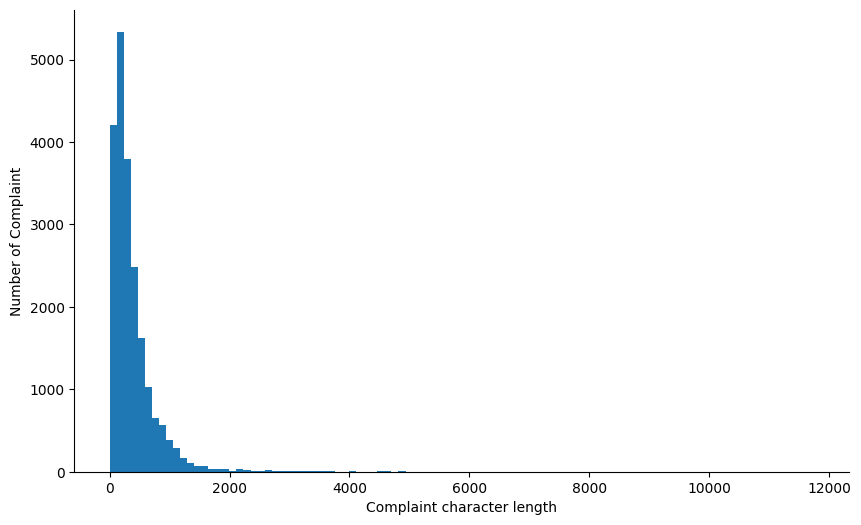

In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

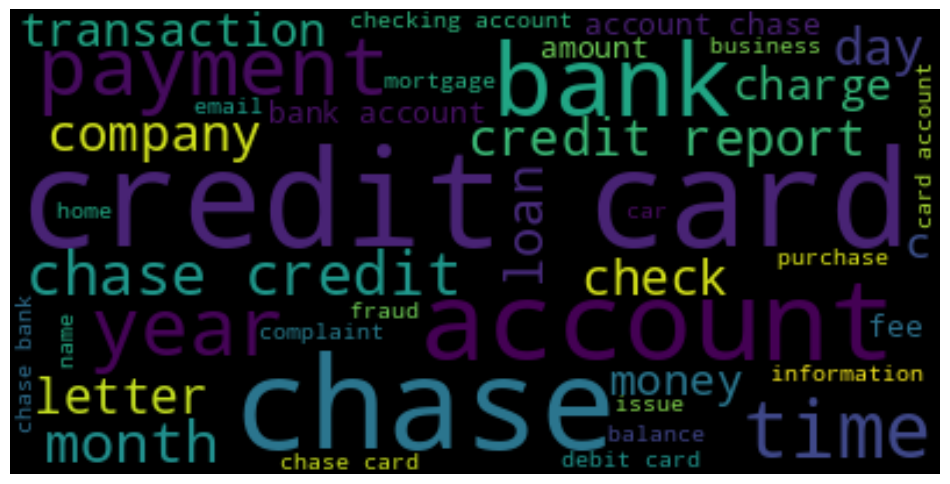

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [60]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.head(20)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,3
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
17,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restricted my...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,3
20,during the summer months i eperience a decline...,during the summer month i eperience a decline ...,summer month decline income employment month p...,summer month decline income employment month p...,4
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,1


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [24]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_clean['complaints'])
    count_values = grams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
    return df_ngram


In [25]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')
df_unigram = top_grams(1)
df_unigram.head(10)

Top 10 unigrams:



,frequency,unigram
0,80853,chase
1,42751,account
2,32812,credit
3,26946,card
4,26765,bank
5,20364,would
6,16383,told
7,14127,payment
8,13477,called
9,12877,received


In [26]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
df_bigram = top_grams(2)
df_bigram.head(30)

,frequency,unigram
0,12734,chase bank
1,10941,credit card
2,3709,called chase
3,3569,checking account
4,3253,credit report
5,3021,customer service
6,2714,jp morgan
7,2567,morgan chase
8,2534,chase credit
9,1997,account chase


In [27]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
df_trigram = top_grams(3)
df_trigram.head(30)

,frequency,unigram
0,2230,jp morgan chase
1,1982,chase credit card
2,773,credit card company
3,692,morgan chase bank
4,666,credit card account
5,560,chase customer service
6,554,account chase bank
7,552,credit card chase
8,457,received letter chase
9,438,called chase bank


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [28]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [29]:
#All masked texts has been removed
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [30]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [31]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaints'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [32]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [33]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_ #write your code here

In [34]:
#nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

14985

In [35]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,fraud,called,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,debt,removed
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,bank,years,sale,morgan,rate,jp
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,month,fees,fee,statement,auto,account,chase,charged,monthly


In [36]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4])

In [37]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [38]:
df_clean.head()


,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,3


In [39]:
#Print the first 5 Complaint for each of the Topics
First5_comp=df_clean.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
43,chase sent me an email today with the innocuou...,chase sent me an email today with the innocuou...,chase email today title information change cha...,chase email today title information change cha...,0
40,a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and wa never ...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase catering order brother funeral amount ch...,chase catering order brother funeral amount ch...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,1
26,i have reached out to several times in attempt...,i have reached out to several time in attempt ...,time attempt inquiry creditor inquiry report a...,time attempt inquiry creditor inquiry report a...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [40]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [59]:
df_clean.head(20)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,3
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
17,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restricted my...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,3
20,during the summer months i eperience a decline...,during the summer month i eperience a decline ...,summer month decline income employment month p...,summer month decline income employment month p...,4
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,1


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [42]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [58]:
df_clean.head(20)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,3
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
17,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restricted my...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,3
20,during the summer months i eperience a decline...,during the summer month i eperience a decline ...,summer month decline income employment month p...,summer month decline income employment month p...,4
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,1


In [44]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.drop(['lemmatized', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [57]:
training_data.head(10)

,complaints,Topic
1,good morning my name is and i appreciate it if...,2
2,i upgraded my card in and was told by the agen...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came across...,1
14,my grand son give me check for i deposit it in...,3
15,can you please remove inquiry,1
17,with out notice j p morgan chase restricted my...,3
20,during the summer months i eperience a decline...,4
21,on i made a payment to an online retailer usin...,0
23,i have a chase credit card which is incorrectl...,1


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [46]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)
# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [48]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

#### 1. Logistic Regression

In [49]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       944
           1       0.96      0.95      0.96       914
           2       0.98      0.95      0.96       714
           3       0.94      0.98      0.96      1123
           4       0.97      0.90      0.93       520

    accuracy                           0.95      4215
   macro avg       0.96      0.95      0.95      4215
weighted avg       0.95      0.95      0.95      4215



#### 2. Decision tree classifier

In [50]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       944
           1       0.79      0.80      0.80       914
           2       0.78      0.81      0.80       714
           3       0.80      0.80      0.80      1123
           4       0.70      0.68      0.69       520

    accuracy                           0.77      4215
   macro avg       0.76      0.76      0.76      4215
weighted avg       0.77      0.77      0.77      4215



#### 3. Random Forest

In [51]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       944
           1       0.77      0.77      0.77       914
           2       0.88      0.78      0.83       714
           3       0.61      0.97      0.75      1123
           4       0.96      0.29      0.44       520

    accuracy                           0.74      4215
   macro avg       0.81      0.69      0.70      4215
weighted avg       0.78      0.74      0.73      4215



#### 4. Gaussian Naive Bayes

In [52]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))


              precision    recall  f1-score   support

           0       0.48      0.35      0.40       944
           1       0.35      0.27      0.30       914
           2       0.52      0.50      0.51       714
           3       0.46      0.30      0.37      1123
           4       0.18      0.51      0.27       520

    accuracy                           0.36      4215
   macro avg       0.40      0.38      0.37      4215
weighted avg       0.42      0.36      0.37      4215



### Infering the best model

In [53]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [54]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]


In [55]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Others
2,I want to open a salary account at your downto...,Credit card or prepaid card
3,"Yesterday, I received a fraudulent email regar...",Account Services
4,What is the procedure to know my CIBIL score?,Mortgage/Loan
5,I need to know the number of bank branches and...,Credit card or prepaid card
